# Pipeline for High-z Radio Galaxies 07: Application of full pipeline for prediction with naive thresholds

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd
import mpl_scatter_density
from joblib import dump, load
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

Functions to predict values

In [3]:
def predict_star(catalog_df, star_model, cal_str_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(star_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_1'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    catalog_df.loc[:, 'Score_no_star'] = np.around(catalog_df.loc[:, 'Score_no_star'], decimals=7)
    pred_probs = cal_str_model.predict_proba(catalog_df.loc[:, gf.get_final_column_names(star_model, catalog_df)])[:, 0]
    catalog_df['Prob_no_star'] = pred_probs
    return catalog_df

In [4]:
def predict_AGN_gal(catalog_df, AGN_gal_model, cal_AGN_gal_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(AGN_gal_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
    catalog_df.loc[:, 'Score_AGN'] = np.around(catalog_df.loc[:, 'Score_AGN'], decimals=7)
    pred_probs = cal_AGN_gal_model.predict_proba(catalog_df.loc[:, gf.get_final_column_names(AGN_gal_model, catalog_df)])[:, 1]
    catalog_df['Prob_AGN'] = pred_probs
    return catalog_df

In [5]:
def predict_radio_det(catalog_df, radio_model, cal_radio_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(radio_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
    catalog_df.loc[:, 'Score_radio'] = np.around(catalog_df.loc[:, 'Score_radio'], decimals=7)
    pred_probs = cal_radio_model.predict_proba(catalog_df.loc[:, gf.get_final_column_names(radio_model, catalog_df)])[:, 1]
    catalog_df['Prob_radio'] = pred_probs
    return catalog_df

In [6]:
def predict_z_full(catalog_df, redshift_model):
    catalog_df = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    catalog_df = catalog_df.rename(columns={'Label': 'pred_Z'})
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [7]:
def predict_z_high(catalog_df, redshift_model, z_lim, z_tol):
    catalog_df    = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    filter_pred_z = catalog_df.loc[:, 'pred_Z'] >= (z_lim + z_tol)
    catalog_df.loc[:, 'pred_Z'] = catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, catalog_df.loc[filter_pred_z, 'Label'])
    catalog_df    = catalog_df.drop(columns=['Label'])
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [8]:
def M12_AGN_criterion(catalog_df):
    M12_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           -3.172 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)
    return M12_column

In [9]:
def S12_AGN_criterion(catalog_df):
    S12_column = np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)
    return S12_column

In [10]:
def M16_AGN_criterion(catalog_df):
    M16_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)
    return M16_column

In [11]:
def B18_AGN_criterion(catalog_df):
    B18_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           2 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)
    return B18_column

In [12]:
def add_AGN_criteria(catalog_df):
    catalog_df['M12_AGN'] = M12_AGN_criterion(catalog_df)
    catalog_df['S12_AGN'] = S12_AGN_criterion(catalog_df)
    catalog_df['M16_AGN'] = M16_AGN_criterion(catalog_df)
    catalog_df['B18_AGN'] = B18_AGN_criterion(catalog_df)
    return catalog_df

---

## Reading data

Flags.

In [13]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0 ***
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [14]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Validation, Training, Test, Test+Train

In [15]:
if used_area != 'S82':
    compare_A17_flag = False

In [16]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [17]:
feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [18]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [19]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Create features with class and combined redshift.

In [20]:
if use_zeroth_model:
    full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)
elif not use_zeroth_model:
    full_catalog_df['is_str'] = np.zeros_like(full_catalog_df.loc[:, 'spCl'])

In [21]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [22]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

Show early statistics of confirmed sources

In [23]:
print(f'In the {used_area} field, there are {np.sum(full_catalog_df.loc[:, "class"] != 0.5):,} confirmed sources.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 0):,} of them are galaxies.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 1):,} of them are AGN.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 2):,} of them are stars.')

In the HETDEX field, there are 83,409 confirmed sources.
55,158 of them are galaxies.
28,251 of them are AGN.
0 of them are stars.


---

Split dataset if from HETDEX

In [24]:
if used_area == 'HETDEX':
    if use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
            (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
    elif not use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                        random_state=gv.seed, stratify=full_catalog_df.loc[:, 'class'])
    train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                        random_state=gv.seed, stratify=train_test_df.loc[:, 'class'])
    print('Shape of used data in HETDEX')
    print('(Confirmed galaxies and AGN)')
    print('-' * 50)
    print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
    print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
    print(f'Training data:                      {train_df.shape}')
    print(f'Testing data:                       {test_df.shape}')
    print(f'Unseen Data For Validation:         {validation_df.shape}')
    print('-' * 50)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                        'Validation': validation_df}
    full_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
(Confirmed galaxies and AGN)
--------------------------------------------------
Full confirmed dataset size:        (83409, 100)
Data for Modeling (Train and Test): (66727, 100)
Training data:                      (46708, 100)
Testing data:                       (20019, 100)
Unseen Data For Validation:         (16682, 100)
--------------------------------------------------

Using Validation data from HETDEX


Split data if not from HETDEX

In [25]:
if used_area != 'HETDEX':
    filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                       (full_catalog_df.loc[:, 'class'] == 1) |\
                       (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
    full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [26]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (16682, 100)
--------------------------------------------------
Thus, it has 16,682 sources and 100 features.


Discard minor features.

In [27]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [28]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)     # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # 
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)        # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)    # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)          # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)   # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)   # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Predictions with naive thresholds ($0.5$).

In [29]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = predict_star(full_catalog_df, star_clf, cal_star_clf, gv.naive_star_thresh, gv.naive_star_thresh)
    unknown_cat_df  = predict_star(unknown_cat_df,  star_clf, cal_star_clf, gv.naive_star_thresh, gv.naive_star_thresh)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1
    full_catalog_df['Prob_no_star']  = 1
    unknown_cat_df['pred_star']      = 0
    unknown_cat_df['Score_no_star']  = 1
    unknown_cat_df['Prob_no_star']   = 1

In [30]:
full_catalog_df = predict_AGN_gal(full_catalog_df, AGN_gal_clf, cal_AGN_gal_clf, gv.naive_AGN_thresh, gv.naive_AGN_thresh)
unknown_cat_df  = predict_AGN_gal(unknown_cat_df,  AGN_gal_clf, cal_AGN_gal_clf, gv.naive_AGN_thresh, gv.naive_AGN_thresh)

In [31]:
full_catalog_df = predict_radio_det(full_catalog_df, radio_det_clf, cal_radio_det_clf, gv.naive_radio_thresh, gv.naive_radio_thresh)
unknown_cat_df  = predict_radio_det(unknown_cat_df,  radio_det_clf, cal_radio_det_clf, gv.naive_radio_thresh, gv.naive_radio_thresh)

In [32]:
full_catalog_df = predict_z_full(full_catalog_df, redshift_reg)
unknown_cat_df  = predict_z_full(unknown_cat_df,  redshift_reg)

Additional columns with predictions.

In [33]:
full_catalog_df['pred_prob_star']  = (full_catalog_df.loc[:, 'Prob_no_star'] < (1 - gv.cal_str_thresh)).astype(int)
full_catalog_df['pred_prob_class'] = (full_catalog_df.loc[:, 'Prob_AGN']    >= gv.naive_AGN_thresh).astype(int)
full_catalog_df['pred_prob_radio'] = (full_catalog_df.loc[:, 'Prob_radio']  >= gv.naive_radio_thresh).astype(int)

unknown_cat_df['pred_prob_star']   = (unknown_cat_df.loc[:, 'Prob_no_star'] < (1 - gv.cal_str_thresh)).astype(int)
unknown_cat_df['pred_prob_class']  = (unknown_cat_df.loc[:, 'Prob_AGN']    >= gv.naive_AGN_thresh).astype(int)
unknown_cat_df['pred_prob_radio']  = (unknown_cat_df.loc[:, 'Prob_radio']  >= gv.naive_radio_thresh).astype(int)

Scores before applying further z models

In [34]:
if use_zeroth_model:
    temp_filt_pred_nstr    = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN        = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_early            = gf.sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_nmad_early           = gf.sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_early              = gf.sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_norm_early         = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
out_frac_early             = gf.outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])

In [35]:
if use_zeroth_model:
    temp_filt_pred_nstr_prob    = np.array(full_catalog_df.loc[:, 'pred_prob_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr_prob    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN_prob   = np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_prob_radio'] == 1) &\
                             temp_filt_pred_nstr_prob
sigma_mad_prob_early       = gf.sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early      = gf.sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_prob_early         = gf.sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early    = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
out_frac_prob_early        = gf.outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])

In [36]:
temp_filt_high_z_rAGN       = temp_filt_pred_rAGN * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_early_hiz         = gf.sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_nmad_early_hiz        = gf.sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_early_hiz           = gf.sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_norm_early_hiz      = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
out_frac_early_hiz          = gf.outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])

temp_filt_high_z_rAGN_prob  = temp_filt_pred_rAGN_prob * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_early_hiz    = gf.sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early_hiz   = gf.sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_prob_early_hiz      = gf.sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early_hiz = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
out_frac_prob_early_hiz     = gf.outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])

In [37]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = predict_z_high(full_catalog_df, redshift_reg_2, gv.high_z_limit, redshift_tol)
    unknown_cat_df  = predict_z_high(unknown_cat_df,  redshift_reg_2, gv.high_z_limit, redshift_tol)

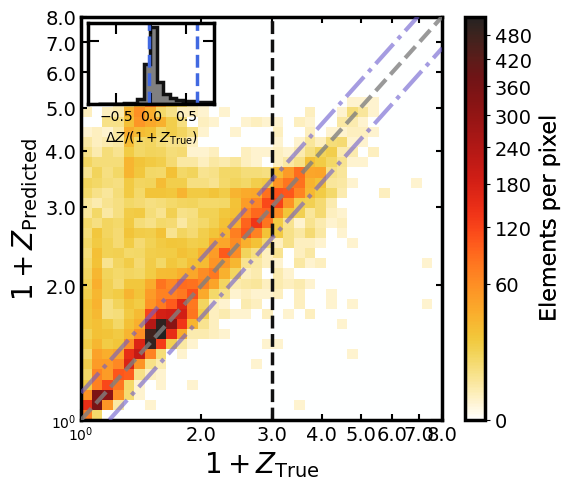

In [38]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + gv.high_z_limit), ls='--', c='k', lw=2.5)
if use_second_z_model:
    ax1.set_ylabel('$1 + Z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

Additional columns with radio AGN prediction as a whole.

In [39]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['pred_prob_rAGN']     = np.array(full_catalog_df.loc[:, 'pred_prob_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_prob_radio'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_no_star'] *\
                                        full_catalog_df.loc[:, 'Score_AGN'] *\
                                        full_catalog_df.loc[:, 'Score_radio']
full_catalog_df['Prob_rAGN']          = full_catalog_df.loc[:, 'Prob_no_star'] *\
                                        full_catalog_df.loc[:, 'Prob_AGN'] *\
                                        full_catalog_df.loc[:, 'Prob_radio']
rad_score_scaler                      = MinMaxScaler()
rad_score_scaler.fit(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_radio'] = rad_score_scaler.transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [40]:
unknown_cat_df['pred_radio_AGN']     = np.array(unknown_cat_df.loc[:, 'pred_star']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
unknown_cat_df['pred_prob_rAGN']     = np.array(unknown_cat_df.loc[:, 'pred_prob_star']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_prob_class'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_prob_radio'] == 1)
unknown_cat_df['Score_rAGN']         = unknown_cat_df.loc[:, 'Score_no_star'] *\
                                       unknown_cat_df.loc[:, 'Score_AGN'] *\
                                       unknown_cat_df.loc[:, 'Score_radio']
unknown_cat_df['Prob_rAGN']          = unknown_cat_df.loc[:, 'Prob_no_star'] *\
                                       unknown_cat_df.loc[:, 'Prob_AGN'] *\
                                       unknown_cat_df.loc[:, 'Prob_radio']

unknown_cat_df['scaled_score_radio'] = rad_score_scaler.transform(unknown_cat_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
unknown_cat_df['scaled_score_rAGN']  = unknown_cat_df.loc[:, 'Score_AGN'] * unknown_cat_df.loc[:, 'scaled_score_radio']

In [41]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'pred_prob_class', 'radio_detect', 'pred_radio', 'pred_prob_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
full_catalog_df.loc[:, displayed_cols].describe()

,class,pred_class,pred_prob_class,radio_detect,pred_radio,pred_prob_radio,Z,pred_Z
count,16682.000000,16682.000000,16682.000000,16682.000000,16682.00000,16682.000000,16682.000000,16682.000000
mean,0.338688,0.331255,0.237621,0.290673,0.53261,0.145546,0.819600,1.249113
std,0.473278,0.470679,0.425639,0.454086,0.49895,0.352661,0.727469,0.999578
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.003570,0.025800
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.338275,0.525425
50%,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.578000,0.875400
75%,1.000000,1.000000,0.000000,1.000000,1.00000,0.000000,1.065750,1.886050
max,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,6.440000,4.678800


##### Include AGN detection criteria from literature

In [42]:
full_catalog_df = add_AGN_criteria(full_catalog_df)
unknown_cat_df  = add_AGN_criteria(unknown_cat_df)

Obtain intermediate metrics

In [43]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
if use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1) |\
                        (full_catalog_df.loc[:, 'class'] == 2)
elif not use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_gal_t            = np.array(full_catalog_df.loc[:, 'class'] == 0)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_str_t            = np.array(full_catalog_df.loc[:, 'class'] == 2)
filter_radio_t          = np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)
num_str_t               = np.sum(filter_str_t)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(filter_gal_t)
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_radio_t             = np.sum(filter_radio_t)
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [44]:
if use_zeroth_model:
    filter_non_str_p      = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_p      = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_p        = full_catalog_df['pred_radio_AGN']
filt_hiz_rAGN_p           = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_p              = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p
filter_radio_p            = np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_p           = filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)
num_str_p                 = np.sum(full_catalog_df.loc[:, 'pred_star'] == 1)
num_AGN_p                 = np.sum(filter_AGN_p)
num_gal_p                 = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p)
num_radio_p               = np.sum(filter_radio_p)
num_radio_AGN_p           = np.sum(filter_radio_AGN_p)
num_rAGN_MQC_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_p            = np.sum(filter_radio_AGN_p) - np.sum(filter_radio_AGN_t)

Some metrics for predicted classes based on probabilities (not scores).

In [45]:
if use_zeroth_model:
    filter_non_str_prob_p = np.array(full_catalog_df.loc[:, 'pred_prob_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_prob_p = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_prob_p   = full_catalog_df['pred_prob_rAGN']
filt_hiz_rAGN_prob_p      = filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_prob_p         = np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 1) & filter_non_str_prob_p
filter_radio_prob_p       = np.array(full_catalog_df.loc[:, 'pred_prob_radio'] == 1)
filt_new_rAGN_prob_p      = filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)

num_AGN_prob_p            = np.sum(filter_AGN_prob_p)
num_gal_prob_p            = np.sum(np.array(full_catalog_df.loc[:, 'pred_prob_class'] == 0) & filter_non_str_prob_p)
num_radio_prob_p          = np.sum(filter_radio_prob_p)
num_radio_AGN_prob_p      = np.sum(filter_radio_AGN_prob_p)
num_rAGN_MQC_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_prob_p       = np.sum(filter_radio_AGN_prob_p) - np.sum(filter_radio_AGN_t)

In [46]:
if use_zeroth_model:
    filter_non_str_unk_p      = np.array(unknown_cat_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_p      = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_p        = unknown_cat_df['pred_radio_AGN']
filt_hiz_rAGN_unk_p           = filter_radio_AGN_unk_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_p              = np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) & filter_non_str_unk_p
filter_radio_unk_p            = np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_unk_p           = filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)
num_str_unk_p                 = np.sum(unknown_cat_df.loc[:, 'pred_star'] == 1)
num_AGN_unk_p                 = np.sum(filter_AGN_unk_p)
num_gal_unk_p                 = np.sum(np.array(unknown_cat_df.loc[:, 'pred_class'] == 0) & filter_non_str_unk_p)
num_radio_unk_p               = np.sum(filter_radio_unk_p)
num_radio_AGN_unk_p           = np.sum(filter_radio_AGN_unk_p)
num_rAGN_MQC_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'radio_detect'] == 1))

In [47]:
if use_zeroth_model:
    filter_non_str_unk_prob_p = np.array(unknown_cat_df.loc[:, 'pred_prob_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_prob_p = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_prob_p   = unknown_cat_df['pred_prob_rAGN']
filt_hiz_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_prob_p         = np.array(unknown_cat_df.loc[:, 'pred_prob_class'] == 1) & filter_non_str_unk_prob_p
filter_radio_unk_prob_p       = np.array(unknown_cat_df.loc[:, 'pred_prob_radio'] == 1)
filt_new_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)

num_AGN_unk_prob_p            = np.sum(filter_AGN_unk_prob_p)
num_gal_unk_prob_p            = np.sum(np.array(unknown_cat_df.loc[:, 'pred_prob_class'] == 0) & filter_non_str_unk_prob_p)
num_radio_unk_prob_p          = np.sum(filter_radio_unk_prob_p)
num_radio_AGN_unk_prob_p      = np.sum(filter_radio_AGN_unk_prob_p)
num_rAGN_MQC_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'radio_detect'] == 1))
num_new_rAGN_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p) - np.sum(filter_radio_AGN_t)

Confusion matrix for Star/not-star classification on confirmed sources (AGN + Galaxies + Stars)

In [48]:
if use_zeroth_model:
    cm_str = gf.conf_mat_func(full_catalog_df.loc[:, 'is_str'], full_catalog_df.loc[:, 'pred_star'])

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies). Including initial prediction of not being star.

In [49]:
tmp_filt_AGN = filter_non_str_p * filter_known_spec
cm_AGN      = gf.conf_mat_func(full_catalog_df.loc[filter_non_str_p, 'class'],\
        full_catalog_df.loc[filter_non_str_p, 'pred_class'])
cm_AGN_prob = gf.conf_mat_func(full_catalog_df.loc[filter_non_str_p, 'class'],\
        full_catalog_df.loc[filter_non_str_p, 'pred_prob_class'])

Confusion matrices from literature AGN criteria.

In [50]:
tmp_filt_sp_nostr = filter_known_spec * filter_non_str_p
cm_AGN_S12 = np.array([[np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[filter_non_str_p, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[filter_non_str_p, 'S12_AGN'] == 1))]])

cm_AGN_M12 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'] == 1))]])

cm_AGN_M16 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'] == 1))]])

cm_AGN_B18 = np.array([[np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                               np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 0) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 1))],\
            [np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 0)),\
             np.sum(np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'] == 1) &\
                    np.array(full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'] == 1))]])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies/stars)

In [51]:
cm_radio = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_p, 'pred_radio']   == 1))]])

cm_radio_prob = np.array([[np.sum(np.array(full_catalog_df.loc[filter_AGN_prob_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_prob_p, 'pred_prob_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_prob_p, 'radio_detect'] == 0) &\
                             np.array(full_catalog_df.loc[filter_AGN_prob_p, 'pred_prob_radio']   == 1))],\
                     [np.sum(np.array(full_catalog_df.loc[filter_AGN_prob_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_prob_p, 'pred_prob_radio']   == 0)),\
                      np.sum(np.array(full_catalog_df.loc[filter_AGN_prob_p, 'radio_detect'] == 1) &\
                             np.array(full_catalog_df.loc[filter_AGN_prob_p, 'pred_prob_radio']   == 1))]])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies/stars)

In [52]:
cm_rAGN      = gf.conf_mat_func(full_catalog_df.loc[:, 'radio_AGN'], full_catalog_df.loc[:,'pred_radio_AGN'])
cm_rAGN_prob = gf.conf_mat_func(full_catalog_df.loc[:, 'radio_AGN'], full_catalog_df.loc[:,'pred_prob_rAGN'])

Metrics from redshift predictions.

In [53]:
sigma_mad_field            = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

sigma_mad_prob_field       = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field      = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_prob_field         = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field    = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
out_frac_prob_field        = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])

In [54]:
filt_high_z_rAGN_p         = filter_radio_AGN_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_field_hiz        = gf.sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_nmad_field_hiz       = gf.sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_field_hiz          = gf.sigma_z(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_norm_field_hiz     = gf.sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
out_frac_field_hiz         = gf.outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])

filt_high_z_rAGN_prob_p         = filter_radio_AGN_prob_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_field_hiz        = gf.sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field_hiz       = gf.sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_prob_field_hiz          = gf.sigma_z(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field_hiz     = gf.sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
out_frac_prob_field_hiz         = gf.outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])

Plot histograms for scores.

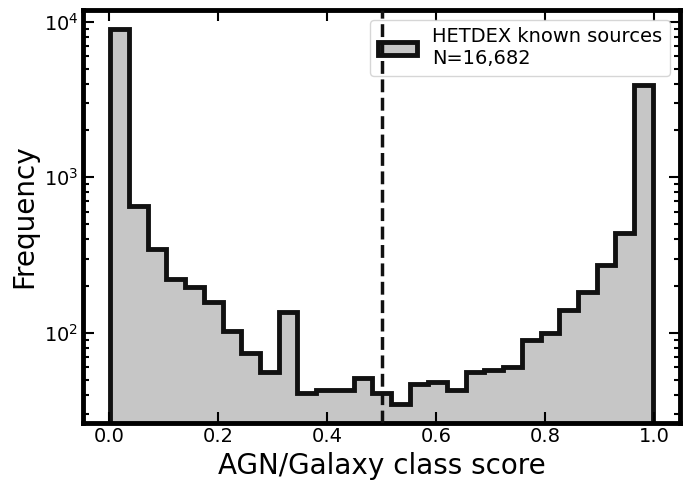

In [55]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_scores_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

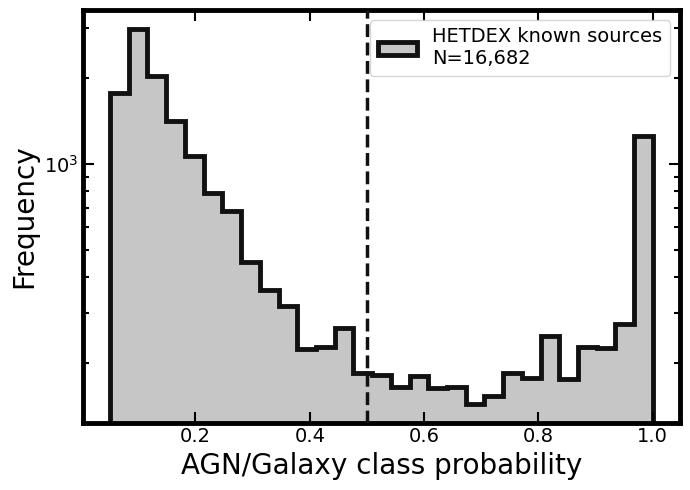

In [56]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

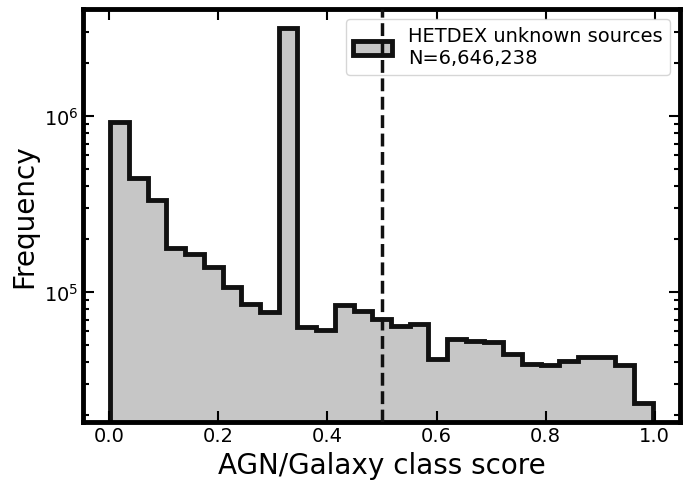

In [57]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_scores_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

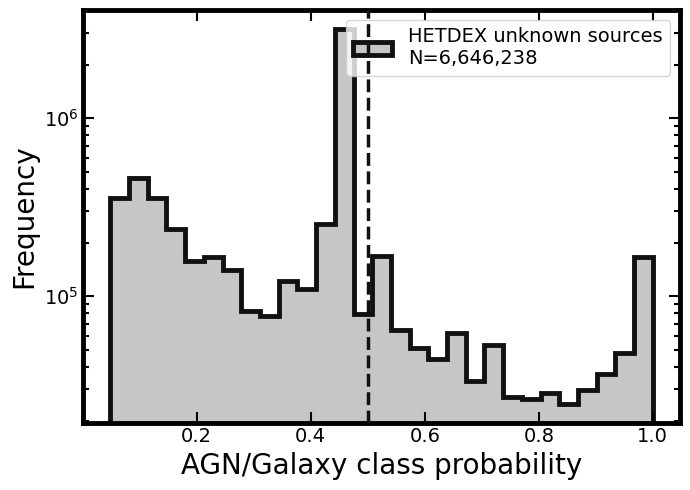

In [58]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

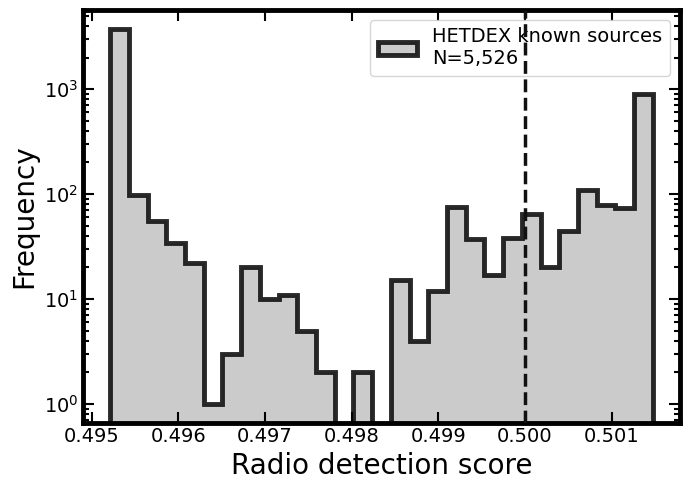

In [59]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_p)

ax1.hist(full_catalog_df.loc[filter_AGN_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_scores_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

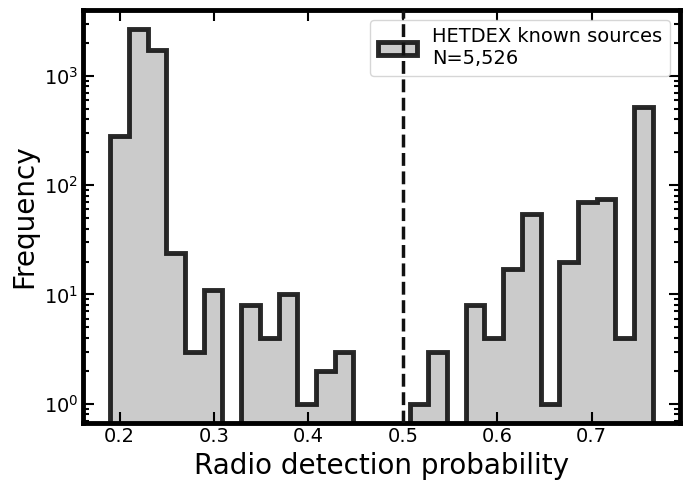

In [60]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_p)

ax1.hist(full_catalog_df.loc[filter_AGN_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_prob_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

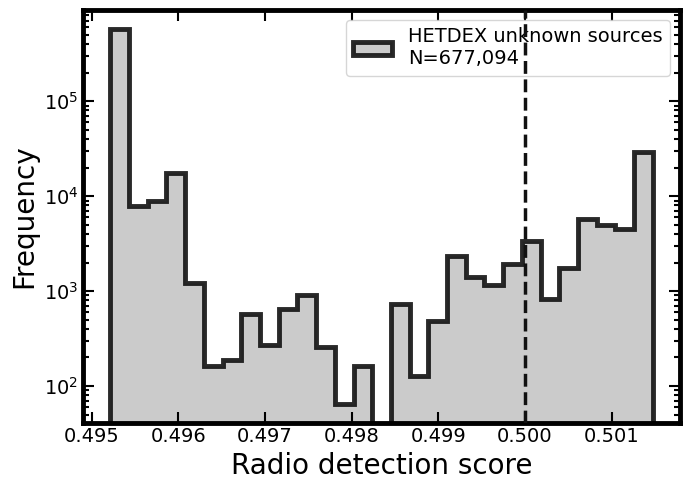

In [61]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_scores_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

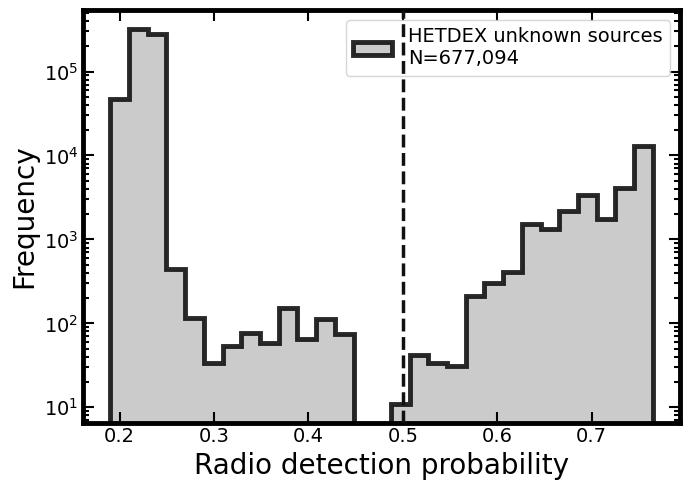

In [62]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_probs_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

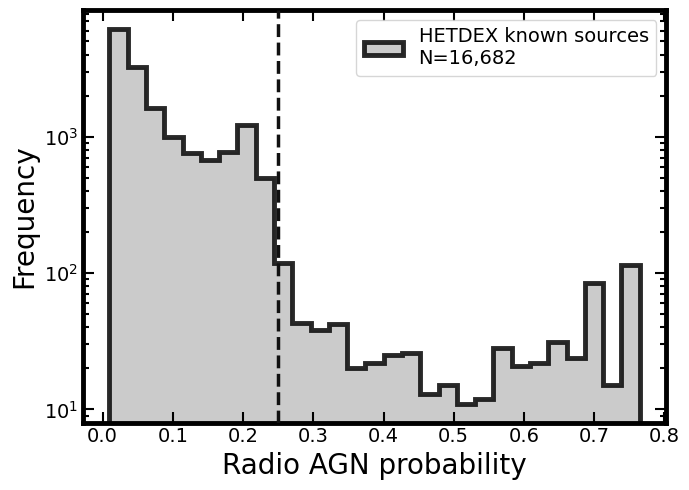

In [63]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
max_score       = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

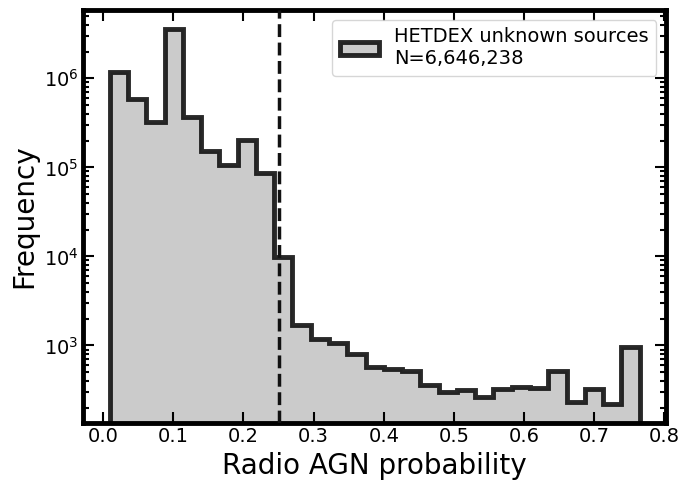

In [64]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

Plot histograms for predicted and original redshifts.

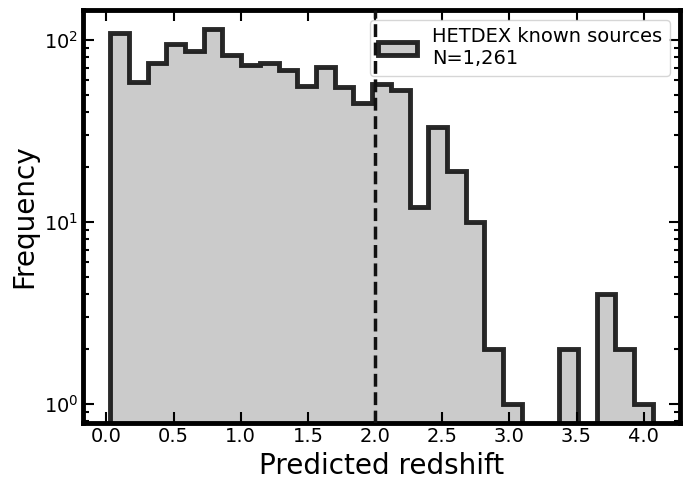

In [65]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_p)

ax1.hist(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_redshift_rAGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

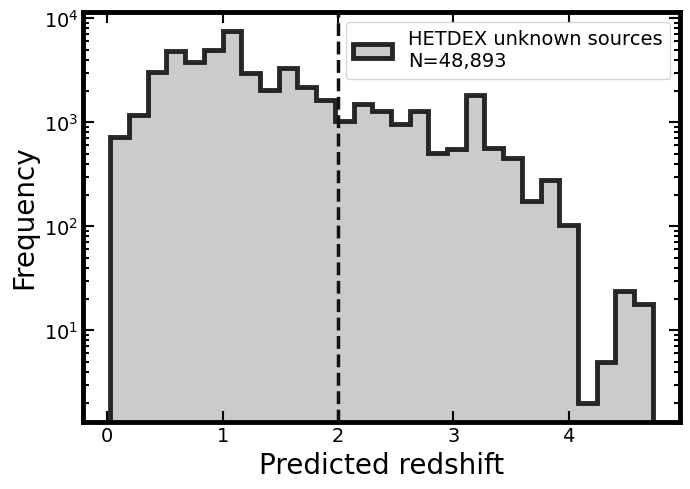

In [66]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_redshift_rAGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

In [67]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'radio_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
print('Predictions for known sources:')
display(full_catalog_df.loc[filter_radio_AGN_p, displayed_cols].describe())
print('\nPredictions for unknown sources:')
display(unknown_cat_df.loc[filter_radio_AGN_unk_p, displayed_cols].describe())

Predictions for known sources:


,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,1261.000000,1261.0,1261.00000,1261.0,1261.000000,1261.000000
mean,0.940523,1.0,0.62728,1.0,1.102367,1.131789
std,0.236608,0.0,0.48372,0.0,0.801726,0.732010
min,0.000000,1.0,0.00000,1.0,0.000000,0.028200
25%,1.000000,1.0,0.00000,1.0,0.467100,0.555000
50%,1.000000,1.0,1.00000,1.0,0.911000,1.015100
75%,1.000000,1.0,1.00000,1.0,1.639000,1.665500
max,1.000000,1.0,1.00000,1.0,4.223000,4.068100



Predictions for unknown sources:


,class,pred_class,radio_detect,pred_radio,Z,pred_Z
count,48893.0,48893.0,48893.000000,48893.0,561.000000,48893.000000
mean,0.5,1.0,0.359233,1.0,0.733993,1.394910
std,0.0,0.0,0.479781,0.0,1.002107,0.851023
min,0.5,1.0,0.000000,1.0,-0.000340,0.026300
25%,0.5,1.0,0.000000,1.0,0.200000,0.786100
50%,0.5,1.0,0.000000,1.0,0.400000,1.119300
75%,0.5,1.0,1.000000,1.0,0.900000,1.811800
max,0.5,1.0,1.000000,1.0,6.879030,4.727600


Add individual metrics for redshift

In [68]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [69]:
str_0_t     = f'Out of {total_size:,} initially known sources in {used_area},\n'
str_1_t     = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t     = f'{num_str_t:,} are listed as SDSS-DR16 stars and {num_AGN_t:,} are MQC AGN.\n'
str_3_t     = f'Also, {num_radio_AGN_t:,} AGN are detected in radio (i.e. Radio Galaxies).'

str_0_kno_p = f'Out of {len(full_catalog_df):,} initially known sources in {used_area},\n'
str_1_kno_p = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_kno_p = f'{num_str_p:,} are predicted as SDSS-DR16 stars and {num_AGN_p:,} are MQC AGN.\n'
str_3_kno_p = f'Also, {num_radio_AGN_p:,} AGN are predicted to bedetected in radio.'

str_0_unk_p = f'Out of {len(unknown_cat_df):,} initially unknown sources in {used_area},\n'
str_1_unk_p = f'{num_gal_unk_p:,} are predicted to be galaxies. On the other side,\n'
str_2_unk_p = f'{num_str_unk_p:,} are predicted as SDSS-DR16 stars and {num_AGN_unk_p:,} are MQC AGN.\n'
str_3_unk_p = f'Also, {num_radio_AGN_unk_p:,} AGN are predicted to be detected in radio.'

In [70]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)

print('-' * 60)
print(str_0_kno_p + str_1_kno_p + str_2_kno_p + str_3_kno_p)
print('-' * 60)

print('-' * 60)
print(str_0_unk_p + str_1_unk_p + str_2_unk_p + str_3_unk_p)
print('-' * 60)

------------------------------------------------------------
Out of 16,682 initially known sources in HETDEX,
11,032 are confirmed to be galaxies. On the other side,
0 are listed as SDSS-DR16 stars and 5,650 are MQC AGN.
Also, 1,662 AGN are detected in radio (i.e. Radio Galaxies).
------------------------------------------------------------
------------------------------------------------------------
Out of 16,682 initially known sources in HETDEX,
11,156 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 5,526 are MQC AGN.
Also, 1,261 AGN are predicted to bedetected in radio.
------------------------------------------------------------
------------------------------------------------------------
Out of 6,646,238 initially unknown sources in HETDEX,
5,969,144 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 677,094 are MQC AGN.
Also, 48,893 AGN are predicted to be detected in radio.
----------------------------

In [71]:
show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                'radio_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

# cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
#                              'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'Z', 'pred_Z']
# cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
#                              'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'pred_Z']
cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'radio_detect',\
                             'Score_radio', 'Score_rAGN', 'Z', 'pred_Z']
cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'radio_detect',\
                             'Score_radio', 'Score_rAGN', 'pred_Z']

In [72]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = show_columns + cols_4_exp_all[used_area] + cols_photo

In [73]:
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= gv.high_z_limit

Display properties of predicted Radio AGN in known sample.

In [74]:
disp_table_known = full_catalog_df.loc[filter_radio_AGN_p, cols_4_table_pred_known].sort_values(by=['pred_Z'], ascending=False).head(5)
display(disp_table_known)

,RA_ICRS,DE_ICRS,band_num,class,Score_AGN,radio_detect,Score_radio,Score_rAGN,Z,pred_Z
3454090,225.784683,52.536716,8,0.0,0.579754,0,0.500979,0.290444,0.44299,4.0681
1984719,183.907364,54.993698,9,1.0,0.871733,1,0.501476,0.437153,4.10700,3.9181
4899124,212.012451,53.865086,9,1.0,0.623845,0,0.500653,0.312330,4.06400,3.8296
4857795,167.644547,48.010307,9,1.0,0.515031,0,0.501391,0.258232,3.93500,3.7714
4867638,215.540436,46.992298,9,1.0,0.882956,1,0.501476,0.442781,3.81200,3.7008


LaTeX display of same table

In [75]:
display(disp_table_known.to_latex())

'\\begin{tabular}{lrrrrrrrrrr}\n\\toprule\n{} &     RA\\_ICRS &    DE\\_ICRS &  band\\_num &  class &  Score\\_AGN &  radio\\_detect &  Score\\_radio &  Score\\_rAGN &        Z &  pred\\_Z \\\\\n\\midrule\n3454090 &  225.784683 &  52.536716 &         8 &    0.0 &   0.579754 &             0 &     0.500979 &    0.290444 &  0.44299 &  4.0681 \\\\\n1984719 &  183.907364 &  54.993698 &         9 &    1.0 &   0.871733 &             1 &     0.501476 &    0.437153 &  4.10700 &  3.9181 \\\\\n4899124 &  212.012451 &  53.865086 &         9 &    1.0 &   0.623845 &             0 &     0.500653 &    0.312330 &  4.06400 &  3.8296 \\\\\n4857795 &  167.644547 &  48.010307 &         9 &    1.0 &   0.515031 &             0 &     0.501391 &    0.258232 &  3.93500 &  3.7714 \\\\\n4867638 &  215.540436 &  46.992298 &         9 &    1.0 &   0.882956 &             1 &     0.501476 &    0.442781 &  3.81200 &  3.7008 \\\\\n\\bottomrule\n\\end{tabular}\n'

Display properties predicted Radio AGN in unknown sample.

In [76]:
disp_table_unk = unknown_cat_df.loc[filter_radio_AGN_unk_p, cols_4_table_pred_unknown].sort_values(by=['pred_Z'], ascending=False).head(5)
display(disp_table_unk)

,RA_ICRS,DE_ICRS,band_num,Score_AGN,radio_detect,Score_radio,Score_rAGN,pred_Z
3410222,201.309235,53.746429,8,0.602275,0,0.501476,0.302026,4.7276
5441869,207.143448,51.065334,8,0.638292,0,0.500979,0.319771,4.6585
3608513,226.045334,53.410820,8,0.619703,0,0.501476,0.310766,4.6585
6385163,197.976929,46.042267,8,0.699670,0,0.501476,0.350868,4.6585
5210113,169.478455,51.184124,8,0.768996,0,0.501223,0.385439,4.6585


LaTeX display of same table

In [77]:
display(disp_table_unk.to_latex())

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n{} &     RA\\_ICRS &    DE\\_ICRS &  band\\_num &  Score\\_AGN &  radio\\_detect &  Score\\_radio &  Score\\_rAGN &  pred\\_Z \\\\\n\\midrule\n3410222 &  201.309235 &  53.746429 &         8 &   0.602275 &             0 &     0.501476 &    0.302026 &  4.7276 \\\\\n5441869 &  207.143448 &  51.065334 &         8 &   0.638292 &             0 &     0.500979 &    0.319771 &  4.6585 \\\\\n3608513 &  226.045334 &  53.410820 &         8 &   0.619703 &             0 &     0.501476 &    0.310766 &  4.6585 \\\\\n6385163 &  197.976929 &  46.042267 &         8 &   0.699670 &             0 &     0.501476 &    0.350868 &  4.6585 \\\\\n5210113 &  169.478455 &  51.184124 &         8 &   0.768996 &             0 &     0.501223 &    0.385439 &  4.6585 \\\\\n\\bottomrule\n\\end{tabular}\n'

Confusion matrix for AGN/galaxy prediction on all sources

In [78]:
MCC_AGN              = gf.MCC_from_CM(cm_AGN)
ACC_AGN              = gf.ACC_from_CM(cm_AGN)
F1_AGN               = gf.F1_from_CM(cm_AGN)
Recall_AGN           = gf.Recall_from_CM(cm_AGN)

MCC_AGN_prob         = gf.MCC_from_CM(cm_AGN_prob)
ACC_AGN_prob         = gf.ACC_from_CM(cm_AGN_prob)
F1_AGN_prob          = gf.F1_from_CM(cm_AGN_prob)
Recall_AGN_prob      = gf.Recall_from_CM(cm_AGN_prob)

Confusion matrix for radio detection prediction on all predicted AGN

In [79]:
MCC_radio            = gf.MCC_from_CM(cm_radio)
ACC_radio            = gf.ACC_from_CM(cm_radio)
F1_radio             = gf.F1_from_CM(cm_radio)
Recall_radio         = gf.Recall_from_CM(cm_radio)

MCC_radio_prob       = gf.MCC_from_CM(cm_radio_prob)
ACC_radio_prob       = gf.ACC_from_CM(cm_radio_prob)
F1_radio_prob        = gf.F1_from_CM(cm_radio_prob)
Recall_radio_prob    = gf.Recall_from_CM(cm_radio_prob)

Confusion matrix for radio AGN detection prediction.

In [80]:
MCC_radio_AGN         = gf.MCC_from_CM(cm_rAGN)
ACC_radio_AGN         = gf.ACC_from_CM(cm_rAGN)
F1_radio_AGN          = gf.F1_from_CM(cm_rAGN)
Recall_radio_AGN      = gf.Recall_from_CM(cm_rAGN)

MCC_radio_AGN_prob    = gf.MCC_from_CM(cm_rAGN_prob)
ACC_radio_AGN_prob    = gf.ACC_from_CM(cm_rAGN_prob)
F1_radio_AGN_prob     = gf.F1_from_CM(cm_rAGN_prob)
Recall_radio_AGN_prob = gf.Recall_from_CM(cm_rAGN_prob)

Join metrics for classification.

In [81]:
metrics_classif      = np.array([[np.sum(filter_known_spec), F1_AGN,       MCC_AGN,       Recall_AGN,       ACC_AGN],\
                                 [np.sum(filter_AGN_p),      F1_radio,     MCC_radio,     Recall_radio,     ACC_radio],\
                                 [np.sum(filter_known_spec), F1_radio_AGN, MCC_radio_AGN, Recall_radio_AGN, ACC_radio_AGN]])
metrics_classif_df   = pd.DataFrame(data=metrics_classif, columns=['Sample', 'F1', 'MCC', 'Recall', 'Accuracy'],\
                                    index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

metrics_classif_prob      = np.array([[np.sum(filter_known_spec), F1_AGN_prob,       MCC_AGN_prob,       Recall_AGN_prob,       ACC_AGN_prob],\
                                 [np.sum(filter_AGN_prob_p),      F1_radio_prob,     MCC_radio_prob,     Recall_radio_prob,     ACC_radio_prob],\
                                 [np.sum(filter_known_spec), F1_radio_AGN_prob, MCC_radio_AGN_prob, Recall_radio_AGN_prob, ACC_radio_AGN_prob]])
metrics_classif_prob_df   = pd.DataFrame(data=metrics_classif_prob, columns=['Sample', 'F1', 'MCC', 'Recall', 'Accuracy'],\
                                    index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

Confusion matrices for AGN criteria from literature

In [82]:
MCC_AGN_S12          = gf.MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = gf.ACC_from_CM(cm_AGN_S12)
F1_AGN_S12           = gf.F1_from_CM(cm_AGN_S12)
Recall_AGN_S12       = gf.Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = gf.MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = gf.ACC_from_CM(cm_AGN_M12)
F1_AGN_M12           = gf.F1_from_CM(cm_AGN_M12)
Recall_AGN_M12       = gf.Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = gf.MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = gf.ACC_from_CM(cm_AGN_M16)
F1_AGN_M16           = gf.F1_from_CM(cm_AGN_M16)
Recall_AGN_M16       = gf.Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = gf.MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = gf.ACC_from_CM(cm_AGN_B18)
F1_AGN_B18           = gf.F1_from_CM(cm_AGN_B18)
Recall_AGN_B18       = gf.Recall_from_CM(cm_AGN_B18)

metrics_AGN_criteria    = np.array([[F1_AGN_S12,     F1_AGN_M12,     F1_AGN_M16,     F1_AGN_B18],\
                                    [MCC_AGN_S12,    MCC_AGN_M12,    MCC_AGN_M16,    MCC_AGN_B18],\
                                    [Recall_AGN_S12, Recall_AGN_M12, Recall_AGN_M16, Recall_AGN_B18],\
                                    [ACC_AGN_S12,    ACC_AGN_M12,    ACC_AGN_M16,    ACC_AGN_B18]]) 

metrics_AGN_criteria_df = pd.DataFrame(data=metrics_AGN_criteria.T, columns=['F1', 'MCC', 'Recall', 'Accuracy'],\
                                       index=['S12', 'M12', 'M16', 'B18'])

Join metrics for regression.

In [83]:
size_rAGN    = np.sum(filter_radio_AGN_p)
size_rAGN_hz = np.sum(filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z    = np.array([[size_rAGN, sigma_mad_early, sigma_nmad_early, sigma_z_early, sigma_z_norm_early, out_frac_early],\
                         [size_rAGN, sigma_mad_field, sigma_nmad_field, sigma_z_field, sigma_z_norm_field, out_frac_field],\
                         [size_rAGN_hz, sigma_mad_early_hiz, sigma_nmad_early_hiz, sigma_z_early_hiz, sigma_z_norm_early_hiz, out_frac_early_hiz],\
                         [size_rAGN_hz, sigma_mad_field_hiz, sigma_nmad_field_hiz, sigma_z_field_hiz, sigma_z_norm_field_hiz, out_frac_field_hiz]])
metrics_z_df = pd.DataFrame(data=metrics_z,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

size_rAGN_prob    = np.sum(filter_radio_AGN_prob_p)
size_rAGN_prob_hz = np.sum(filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z_prob    = np.array([[size_rAGN_prob, sigma_mad_prob_early, sigma_nmad_prob_early, sigma_z_prob_early,\
                               sigma_z_norm_prob_early, out_frac_prob_early],\
                         [size_rAGN_prob, sigma_mad_prob_field, sigma_nmad_prob_field, sigma_z_prob_field,\
                          sigma_z_norm_prob_field, out_frac_prob_field],\
                         [size_rAGN_prob_hz, sigma_mad_prob_early_hiz, sigma_nmad_prob_early_hiz, sigma_z_prob_early_hiz,\
                          sigma_z_norm_prob_early_hiz, out_frac_prob_early_hiz],\
                         [size_rAGN_prob_hz, sigma_mad_prob_field_hiz, sigma_nmad_prob_field_hiz, sigma_z_prob_field_hiz,\
                          sigma_z_norm_prob_field_hiz, out_frac_prob_field_hiz]])
metrics_z_prob_df = pd.DataFrame(data=metrics_z_prob,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

Print metrics

In [84]:
print('Metrics for classification steps along the pipeline using scores to obtain classes.')
metrics_classif_df.loc[:, 'Sample'] = metrics_classif_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_df)

Metrics for classification steps along the pipeline using scores to obtain classes.


,Sample,F1,MCC,Recall,Accuracy
AGN/Galaxy,16682,0.9379,0.9068,0.9276,0.9584
Radio,5526,0.5654,0.4237,0.5146,0.7799
Radio AGN,16682,0.5022,0.4606,0.4416,0.9128


In [85]:
print('Metrics for classification steps along the pipeline using probabilities to obtain classes.')
metrics_classif_prob_df.loc[:, 'Sample'] = metrics_classif_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_prob_df)

Metrics for classification steps along the pipeline using probabilities to obtain classes.


,Sample,F1,MCC,Recall,Accuracy
AGN/Galaxy,16682,0.7537,0.6786,0.6412,0.8581
Radio,3964,0.4011,0.3165,0.2958,0.7800
Radio AGN,16682,0.2562,0.2740,0.1643,0.9050


In [86]:
print('Metrics for AGN detection criteria (from literature).')
print(f'Sample size, N = {np.sum(filter_known_spec):,}')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_AGN_criteria_df)

Metrics for AGN detection criteria (from literature).
Sample size, N = 16,682


,F1,MCC,Recall,Accuracy
S12,0.8153,0.7272,0.7855,0.8795
M12,0.5298,0.5154,0.3623,0.7822
M16,0.6898,0.6360,0.5381,0.8361
B18,0.8168,0.7587,0.7124,0.8918


In [87]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by scores')
metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by scores


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,1261,0.1385,0.0685,0.3916,0.2248,0.1737
Two models,1261,0.1385,0.0685,0.3916,0.2248,0.1737
First model high z,184,0.2483,0.0740,0.6243,0.4051,0.1793
Second model high z,184,0.2483,0.0740,0.6243,0.4051,0.1793


In [88]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities')
metrics_z_prob_df.loc[:, 'Sample'] = metrics_z_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_prob_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,469,0.1317,0.0624,0.3180,0.2184,0.1450
Two models,469,0.1317,0.0624,0.3180,0.2184,0.1450
First model high z,59,0.2068,0.0642,0.3993,0.2279,0.0678
Second model high z,59,0.2068,0.0642,0.3993,0.2279,0.0678


## Plot predictions

### Classifications based on scores

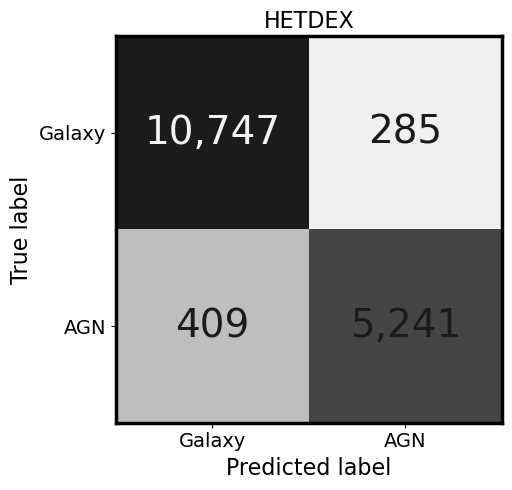

In [89]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

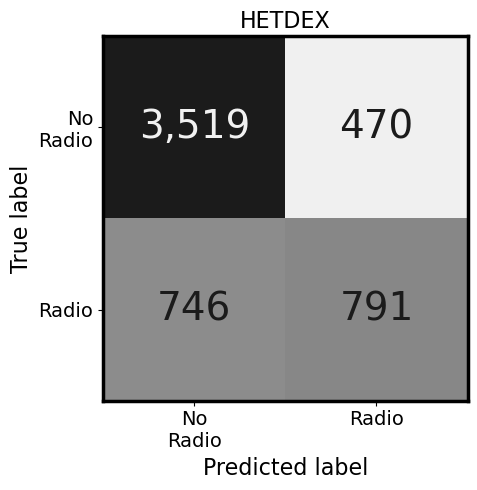

In [90]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

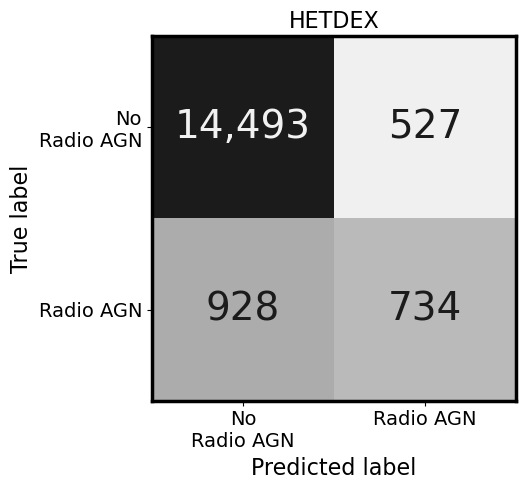

In [91]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_rAGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Classifications based on probabilities

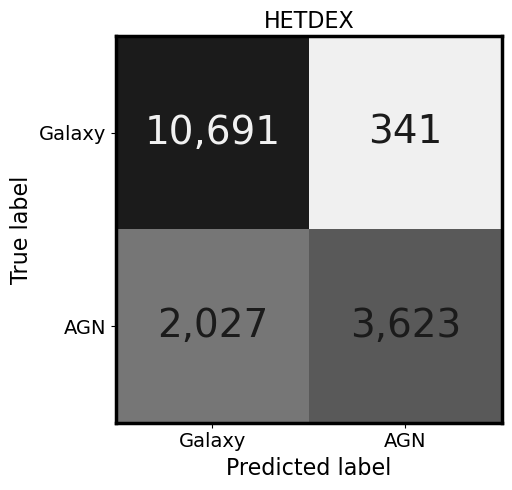

In [92]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_AGN_prob, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

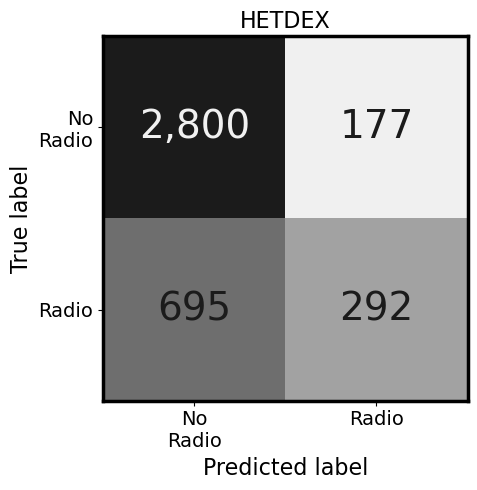

In [93]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_radio_prob, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

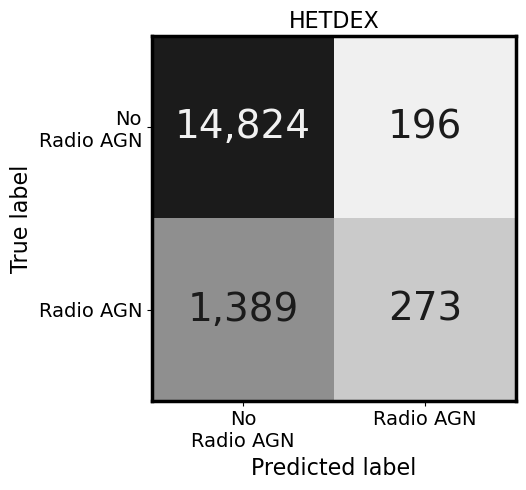

In [94]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_rAGN_prob, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by scores

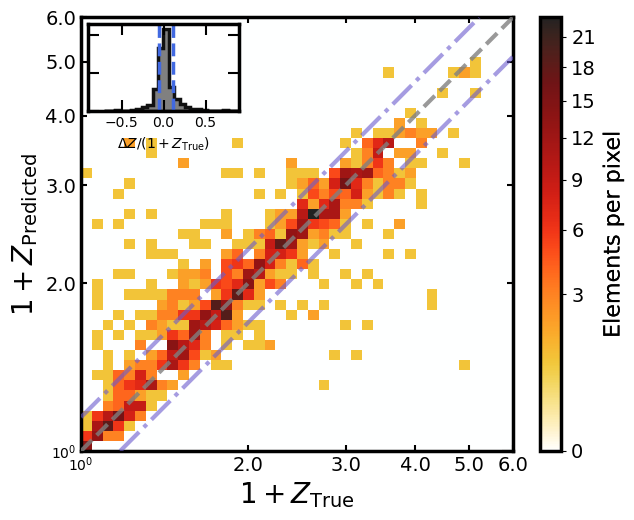

In [95]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by probabilities

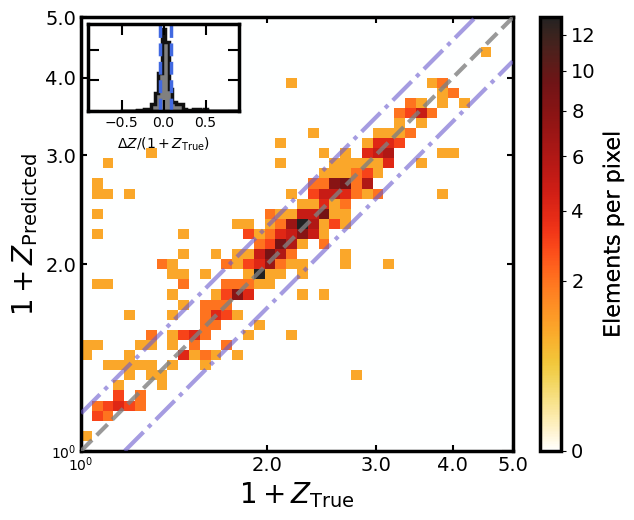

In [96]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Results from unknown sources

In [97]:
unk_summary_AGN_gal                   = unknown_cat_df.loc[:, 'Score_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class']).describe()
unk_summary_AGN_gal_probs             = unknown_cat_df.loc[:, 'Prob_AGN'].groupby(unknown_cat_df.loc[:, 'pred_prob_class']).describe()
unk_summary_radio                     = unknown_cat_df.loc[filter_AGN_unk_p,
                                                         'Score_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_p,
                                                                                                   'pred_radio']).describe()
unk_summary_radio_probs               = unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                         'Prob_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                                                                   'pred_prob_radio']).describe()
unk_summary_z                         = unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'].describe()
unk_summary_z_probs                   = unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'].describe()
unk_summary_AGN_radio                 = pd.concat([unk_summary_AGN_gal, unk_summary_AGN_gal_probs, unk_summary_radio, unk_summary_radio_probs])
unk_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
unk_summary_AGN_radio                 = unk_summary_AGN_radio.set_index('Prediction', drop=True)
unk_summary_AGN_radio.loc['Z']        = unk_summary_z
unk_summary_AGN_radio.loc['Z (prob)'] = unk_summary_z_probs

In [98]:
unk_summary_AGN_radio.loc[:, 'count'] = unk_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(unk_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,5969144,0.24075,0.14241,0.00193,0.07759,0.34319,0.34319,0.50000
AGN,677094,0.71756,0.14203,0.50000,0.58889,0.69851,0.84126,0.99640
Galaxy (prob),5746148,0.35331,0.15722,0.04852,0.18459,0.47334,0.47334,0.50000
AGN (prob),900090,0.73081,0.17964,0.50000,0.54773,0.69511,0.92529,1.00000
No radio,628201,0.49533,0.00057,0.49521,0.49521,0.49521,0.49521,0.49999
Radio,48893,0.50120,0.00039,0.50006,0.50098,0.50148,0.50148,0.50148
No radio (prob),892732,0.22485,0.01371,0.19007,0.21199,0.22371,0.23594,0.49293
Radio (prob),7358,0.69427,0.07118,0.51013,0.63495,0.71814,0.76485,0.76485
Z,48893,1.39491,0.85102,0.02630,0.78610,1.11930,1.81180,4.72760


In [99]:
print(f"In the unknown sources, there are {np.sum(unknown_cat_df.loc[:, 'radio_detect'] == 1):,} radio detected sources.")

In the unknown sources, there are 320,752 radio detected sources.


#### Same idea for known sample.

In [100]:
kno_summary_AGN_gal                   = full_catalog_df.loc[:, 'Score_AGN'].groupby(full_catalog_df.loc[:, 'pred_class']).describe()
kno_summary_AGN_gal_probs             = full_catalog_df.loc[:, 'Prob_AGN'].groupby(full_catalog_df.loc[:, 'pred_prob_class']).describe()
kno_summary_radio                     = full_catalog_df.loc[filter_AGN_p,
                                                         'Score_radio'].groupby(full_catalog_df.loc[filter_AGN_p,
                                                                                                   'pred_radio']).describe()
kno_summary_radio_probs               = full_catalog_df.loc[filter_AGN_prob_p,
                                                         'Prob_radio'].groupby(full_catalog_df.loc[filter_AGN_prob_p,
                                                                                                   'pred_prob_radio']).describe()
kno_summary_z                         = full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'].describe()
kno_summary_z_probs                   = full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'].describe()
kno_summary_AGN_radio                 = pd.concat([kno_summary_AGN_gal, kno_summary_AGN_gal_probs, kno_summary_radio, kno_summary_radio_probs])
kno_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
kno_summary_AGN_radio                 = kno_summary_AGN_radio.set_index('Prediction', drop=True)
kno_summary_AGN_radio.loc['Z']        = kno_summary_z
kno_summary_AGN_radio.loc['Z (prob)'] = kno_summary_z_probs

In [101]:
kno_summary_AGN_radio.loc[:, 'count'] = kno_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(kno_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,11156,0.03829,0.07930,0.00227,0.00477,0.00919,0.02310,0.49962
AGN,5526,0.94614,0.09611,0.50047,0.94890,0.99101,0.99459,0.99738
Galaxy (prob),12718,0.17568,0.10377,0.05073,0.09879,0.14137,0.22478,0.49997
AGN (prob),3964,0.82793,0.15996,0.50018,0.69524,0.86883,0.98266,1.00000
No radio,4265,0.49550,0.00098,0.49521,0.49521,0.49521,0.49521,0.49999
Radio,1261,0.50127,0.00036,0.50006,0.50122,0.50148,0.50148,0.50148
No radio (prob),3495,0.22218,0.01880,0.19007,0.21199,0.21199,0.22973,0.44368
Radio (prob),469,0.72231,0.05488,0.51877,0.70344,0.75189,0.76485,0.76485
Z,1261,1.13179,0.73201,0.02820,0.55500,1.01510,1.66550,4.06810


In [102]:
print(f"In the known sources, there are {np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1):,} radio detected sources.")

In the known sources, there are 4,849 radio detected sources.


#### Some properties from predicted Radio AGN

In [103]:
n_pred_rAGN_AGN_sco      = len(full_catalog_df.loc[filter_radio_AGN_p * filter_AGN_t])
n_pred_rAGN_gal_sco      = len(full_catalog_df.loc[filter_radio_AGN_p * filter_gal_t])
n_pred_rAGN_radio_sco    = len(full_catalog_df.loc[filter_radio_AGN_p * filter_radio_t])
n_pred_rAGN_nonradio_sco = len(full_catalog_df.loc[filter_radio_AGN_p * ~filter_radio_t])

In [104]:
str_rAGN_stats_class_sco = f'From {num_radio_AGN_p:,} sources predicted as rAGN,' +\
                           f' {n_pred_rAGN_gal_sco:,} are galaxies and {n_pred_rAGN_AGN_sco:,} are AGN.'
str_rAGN_stats_radio_sco = f'From {num_radio_AGN_p:,} sources predicted as rAGN, {n_pred_rAGN_radio_sco:,}' +\
                           f' are radio detected and {n_pred_rAGN_nonradio_sco:,} are not.'

In [105]:
print('-' * 80)
print('Statistics from sources predicted to be Radio AGN')
print(f'with scores in the known sources of {used_area}-{HETDEX_subset}')
print()
print(str_rAGN_stats_class_sco)
print(str_rAGN_stats_radio_sco)
print('-' * 80)

--------------------------------------------------------------------------------
Statistics from sources predicted to be Radio AGN
with scores in the known sources of HETDEX-Validation

From 1,261 sources predicted as rAGN, 75 are galaxies and 1,186 are AGN.
From 1,261 sources predicted as rAGN, 791 are radio detected and 470 are not.
--------------------------------------------------------------------------------


In [106]:
n_pred_rAGN_AGN_pro      = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_AGN_t])
n_pred_rAGN_gal_pro      = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_gal_t])
n_pred_rAGN_radio_pro    = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_radio_t])
n_pred_rAGN_nonradio_pro = len(full_catalog_df.loc[filter_radio_AGN_prob_p * ~filter_radio_t])

In [107]:
str_rAGN_stats_class_pro = f'From {num_radio_AGN_prob_p:,} sources predicted as rAGN,' +\
                           f' {n_pred_rAGN_gal_pro:,} are galaxies and {n_pred_rAGN_AGN_pro:,} are AGN.'
str_rAGN_stats_radio_pro = f'From {num_radio_AGN_prob_p:,} sources predicted as rAGN, {n_pred_rAGN_radio_pro:,}' +\
                           f' are radio detected and {n_pred_rAGN_nonradio_pro:,} are not.'

In [108]:
print('-' * 80)
print('Statistics from sources predicted to be Radio AGN')
print(f'with probabilities in the known sources of {used_area}-{HETDEX_subset}')
print()
print(str_rAGN_stats_class_pro)
print(str_rAGN_stats_radio_pro)
print('-' * 80)

--------------------------------------------------------------------------------
Statistics from sources predicted to be Radio AGN
with probabilities in the known sources of HETDEX-Validation

From 469 sources predicted as rAGN, 37 are galaxies and 432 are AGN.
From 469 sources predicted as rAGN, 292 are radio detected and 177 are not.
--------------------------------------------------------------------------------


#### Histograms for predicted sources in unknown sources.

Predictions from scores.

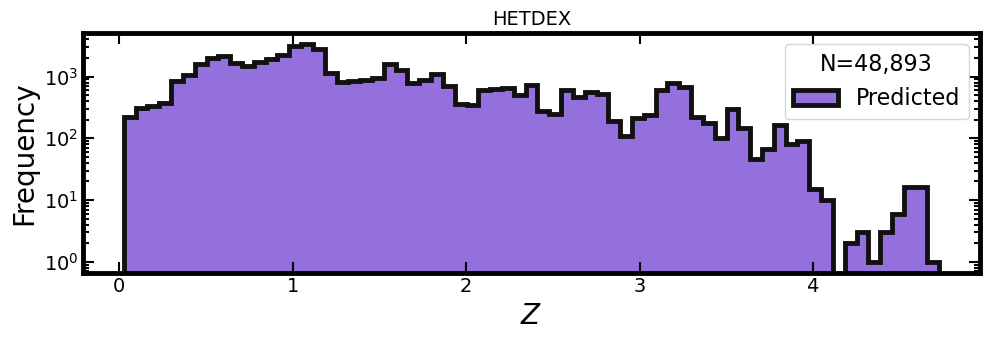

In [109]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_for_range = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_unk_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_{used_area}_unknown.pdf')
plt.show()

Predictions from probabilities.

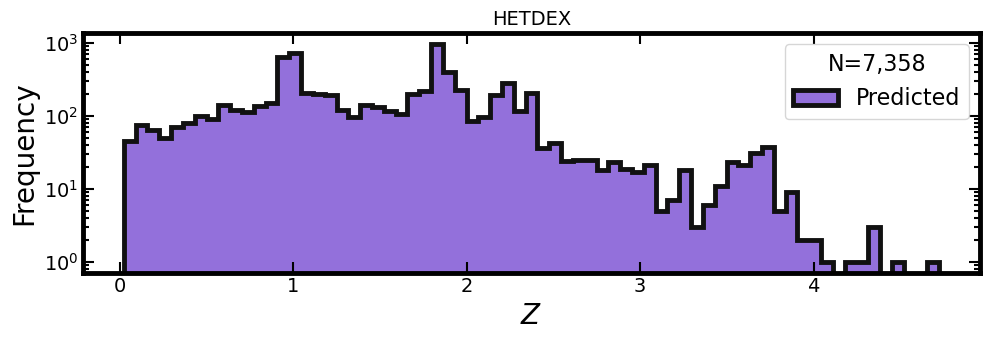

In [110]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'])
max_for_range = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_unk_prob_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_prob_{used_area}_unknown.pdf')
plt.show()

#### Compare probabilities and scores

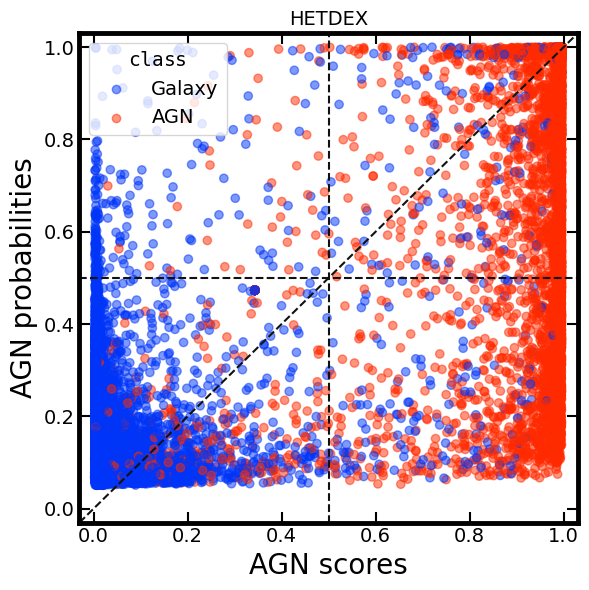

In [111]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.scatter(full_catalog_df.loc[:, 'Score_AGN'], full_catalog_df.loc[:, 'Prob_AGN'], marker='o',\
            alpha=0.5, c=full_catalog_df.loc[:, 'class'],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class']))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=gv.naive_AGN_thresh, color='k', ls='dashed')
ax1.axvline(x=gv.naive_AGN_thresh, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Galaxy',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class'])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class'])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
ax1.set_xlim(left=-0.03, right=1.03)
ax1.set_ylim(bottom=-0.03, top=1.03)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

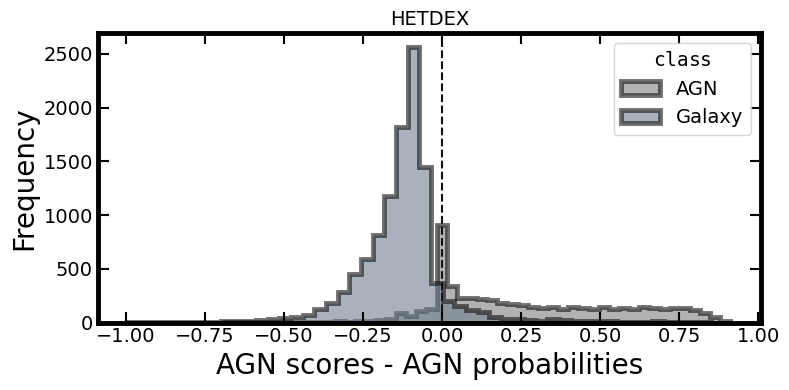

In [112]:
fig             = plt.figure(figsize=(8,4))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

filt_tmp_AGN    = np.array(full_catalog_df.loc[:, 'class'] == 1)

plt.hist((full_catalog_df.loc[filt_tmp_AGN, 'Score_AGN'] - full_catalog_df.loc[filt_tmp_AGN, 'Prob_AGN']),\
         histtype='stepfilled', fc='gray', ec='k', bins=50, lw=3.5, alpha=0.6, label='AGN')
plt.hist((full_catalog_df.loc[~filt_tmp_AGN, 'Score_AGN'] - full_catalog_df.loc[~filt_tmp_AGN, 'Prob_AGN']),\
         histtype='stepfilled', fc='slategray', ec='k', bins=50, lw=3.5, alpha=0.6, label='Galaxy')
plt.axvline(x=0.0, color='k', ls='dashed')
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores - AGN probabilities', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

---

## Additional test with data from Ananna et al., 2017

In [113]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(gv.cat_path + gv.file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [114]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=8)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    redshift_tol   = 0.0
    if use_second_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)

In [115]:
if compare_A17_flag:
    sigma_mad_AGN_A17            = gf.sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_AGN_A17           = gf.sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_AGN_A17              = gf.sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_AGN_A17         = gf.sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_AGN_A17             = gf.outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [116]:
if compare_A17_flag:
    size_AGN_A17         = np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"]))
    metrics_z_AGN_A17    = np.array([size_AGN_A17, sigma_mad_AGN_A17, sigma_nmad_AGN_A17, sigma_z_AGN_A17,
                                     sigma_z_norm_AGN_A17, out_frac_AGN_A17])
    metrics_z_A17_df = pd.DataFrame(columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])
    metrics_z_A17_df.loc['AGN'] = metrics_z_AGN_A17

In [117]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7.5,4.3))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.8,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()

In [118]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'radio_detect'] == 1)]

In [119]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [120]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
        display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [121]:
if compare_A17_flag:
    sigma_mad_rAGN_A17            = gf.sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_rAGN_A17           = gf.sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_rAGN_A17              = gf.sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_rAGN_A17         = gf.sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_rAGN_A17             = gf.outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [122]:
if compare_A17_flag:
    size_rAGN_A17     = np.sum(np.isfinite(full_catalog_A17_df.loc[:, "zsp"]) & np.isfinite(full_catalog_A17_df.loc[:, "pred_Z"]))
    metrics_z_rAGN_A17    = np.array([size_rAGN_A17, sigma_mad_rAGN_A17, sigma_nmad_rAGN_A17, sigma_z_rAGN_A17,
                                 sigma_z_norm_rAGN_A17, out_frac_rAGN_A17])
    metrics_z_A17_df.loc['Radio AGN'] = metrics_z_rAGN_A17

In [123]:
if compare_A17_flag:
    print('Metrics for redshift predictions in all AGN and Radio AGN from Ananna et al., 2017 with counterparts in our sample')
    metrics_z_A17_df.loc[:, 'Sample'] = metrics_z_A17_df.loc[:, 'Sample'].astype(int)
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(metrics_z_A17_df)

In [124]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    _ = gf.plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()